In [1]:
# COMPLETE SETUP:
import sys
import os
import numpy as np

print(f"Python version: {sys.version}")
print(f"Python executable: {sys.executable}")

src_path = os.path.join(os.getcwd(), 'src')
src_path_abs = os.path.abspath(src_path)

waymo_module_path = None
local_src = os.path.abspath(os.path.join(os.getcwd(), 'src', 'waymo_open_dataset'))
if os.path.exists(local_src):
    waymo_module_path = local_src
    src_dir = os.path.abspath(os.path.join(os.getcwd(), 'src'))
    if src_dir not in sys.path:
        sys.path.insert(0, src_dir)   # ensure imports from src work
    print(f"FOUND waymo_open_dataset AT local src: {waymo_module_path}")
else:
    # 2) search existing sys.path entries (original behavior)
    for path in sys.path:
        potential_path = os.path.join(path, 'waymo_open_dataset')
        if os.path.exists(potential_path):
            waymo_module_path = potential_path
            print(f"FOUND waymo_open_dataset IN sys.path AT: {waymo_module_path}.")
            break
if not waymo_module_path:
    print("\twaymo_open_dataset DIRECTORY NOT FOUND IN ANY sys.path LOCATION.")


try:    # Check protobuf version
    import google.protobuf
    protobuf_version = google.protobuf.__version__
    print(f"Protobuf version: {protobuf_version}")
    
    if protobuf_version.startswith('3.20'):
        print("CORRECT protobuf VERSION!")
    else:
        print(f"\tWrong protobuf version ({protobuf_version}), need 3.20.3")
        print("Run this in terminal: conda activate waymo; pip install protobuf==3.20.3 --force-reinstall")
except Exception as e:
    print(f"\tProtobuf ERROR: {e}")


try:    # Test basic imports
    print(f"NumPy version: {np.__version__}")
    
    import tensorflow as tf
    print(f"TensorFlow version: {tf.__version__}")
    print("BASIC IMPORTS SUCCESSFUL.")
except Exception as e:
    print(f"\tBasic imports FAILED: {e}")


try:    # Import Waymo modules
    from waymo_open_dataset import dataset_pb2
    print("dataset_pb2 imported")
    
    from waymo_open_dataset.protos import scenario_pb2
    print("scenario_pb2 imported")
    
    from waymo_open_dataset.utils import womd_camera_utils
    print("womd_camera_utils imported")
    
    # Import additional utility modules for data processing
    from waymo_open_dataset.utils import range_image_utils
    from waymo_open_dataset.utils import transform_utils
    from waymo_open_dataset.utils import frame_utils
    print("Additional utils imported")
    
    print("ALL WAYMO IMPORTS SUCCESSFUL!")
except ImportError as e:
    print(f"\tWaymo import FAILED: {e}")
    print("\nSOLUTIONS:")
    print("1. Make sure you're in the correct directory (waymo-open-dataset/tutorial)")
    print("In /src/waymo_open_dataset you should have libraries (like math, metrics, protos, utils), __pycache__, bazel etc.")
    print("IF NOT: clone the repo: https://github.com/waymo-research/waymo-open-dataset.git")
    print("2. Compile proto files first:")
    print("   - Change to src directory: os.chdir('../src')")
    print("   - Run: subprocess.run(['python', '-m', 'grpc_tools.protoc', '--python_out=.', '--proto_path=.'] + glob.glob('waymo_open_dataset/**/*.proto', recursive=True))")
    print("3. Or run this compilation now:")
    try:    # Try to compile proto files automatically
        import subprocess
        import glob
        current_dir = os.getcwd() # Change to src directory
        src_dir = None
        for potential_src in [os.path.join(current_dir, '..', 'src'),   # Find src directory
                             os.path.join(current_dir, 'src'),
                             r'c:\Users\radov\dev\waymo-open-dataset\src']:
            if os.path.exists(potential_src):
                src_dir = potential_src
                break
        if src_dir:
            print(f"   Found src directory: {src_dir}")
            os.chdir(src_dir)
            # Get proto files
            proto_files = glob.glob('waymo_open_dataset/**/*.proto', recursive=True)
            print(f"   Found {len(proto_files)} proto files")
            if proto_files:
                # Compile proto files
                cmd = ['python', '-m', 'grpc_tools.protoc', '--python_out=.', '--proto_path=.'] + proto_files
                result = subprocess.run(cmd, capture_output=True, text=True)
                
                if result.returncode == 0:
                    print("   Proto FILES COMPILED SUCCESSFULLY!")
                    os.chdir(current_dir)  # Return to original directory
                    print("\tPlease restart the kernel and run this cell again")
                else:
                    print(f"\tProto compilation FAILED: {result.stderr}")
                    os.chdir(current_dir)
            else:
                print("\tNo proto files found")
                os.chdir(current_dir)
        else:
            print("\tCould not find src directory")
    except Exception as compile_error:
        print(f"\tAuto-compilation FAILED: {compile_error}")
except Exception as e:
    print(f"\tUnexpected ERROR: {e}")

camera_names = {1: 'FRONT', 2: 'FRONT_LEFT', 3: 'FRONT_RIGHT', 4: 'SIDE_LEFT', 5: 'SIDE_RIGHT'}
laser_names = {1: 'TOP', 2: 'FRONT', 3: 'SIDE_LEFT', 4: 'SIDE_RIGHT', 5: 'REAR'}
label_types = {1: 'Vehicle', 2: 'Pedestrian', 3: 'Sign', 4: 'Cyclist'}
print("MAPPINGS DEFINED.")

print(f"\nSETUP COMPLETE!")
print(f"If you see any errors above, restart the kernel and run this cell again.")

Python version: 3.9.23 | packaged by conda-forge | (main, Jun  4 2025, 17:49:16) [MSC v.1929 64 bit (AMD64)]
Python executable: c:\Users\radov\.conda\envs\waymo\python.exe
FOUND waymo_open_dataset AT local src: c:\Users\radov\dev\waymo-open-dataset\src\waymo_open_dataset
Protobuf version: 3.20.3
CORRECT protobuf VERSION!
NumPy version: 1.23.5


TensorFlow version: 2.15.0
BASIC IMPORTS SUCCESSFUL.
dataset_pb2 imported
scenario_pb2 imported
womd_camera_utils imported
Additional utils imported
ALL WAYMO IMPORTS SUCCESSFUL!
MAPPINGS DEFINED.

SETUP COMPLETE!
If you see any errors above, restart the kernel and run this cell again.
TensorFlow version: 2.15.0
BASIC IMPORTS SUCCESSFUL.
dataset_pb2 imported
scenario_pb2 imported
womd_camera_utils imported
Additional utils imported
ALL WAYMO IMPORTS SUCCESSFUL!
MAPPINGS DEFINED.

SETUP COMPLETE!
If you see any errors above, restart the kernel and run this cell again.


In [2]:
# TRAINING FILES:
training_files = []
try:
    for filename in os.listdir(r".\data\scenario\training"):
        if filename != '.gitkeep':
            filepath = os.path.join(r".\data\scenario\training", filename)
            if os.path.isfile(filepath):
                training_files.append(filepath)
except Exception as e:
    print(e)
# STRUCTURE OF THE DATA: Multi-agent trajectories, map features, dynamic states in Timestamped agent states + road geometry
#                        max 128 agents per scenario, max 20000 road graph points and max 16 traffic lights

# VALIDATION FILES:
validation_files = []
try:
    for filename in os.listdir(r".\data\scenario\validation"):
        if filename != '.gitkeep':
            filepath = os.path.join(r".\data\scenario\validation", filename)
            if os.path.isfile(filepath):
                validation_files.append(filepath)
except Exception as e:
    print(e)

# TESTING FILES:
testing_files = []
try:
    for filename in os.listdir(r".\data\scenario\testing"):
        if filename != '.gitkeep':
            filepath = os.path.join(r".\data\scenario\testing", filename)
            if os.path.isfile(filepath):
                testing_files.append(filepath)
except Exception as e:
    print(e)

In [3]:
# PARSING FUNCTIONS:
def parse_scenario_file(file):
    scenario_dataset = tf.data.TFRecordDataset(file, compression_type='')
    scenarios = []

    for raw_record in scenario_dataset:
        try:
            scenario = scenario_pb2.Scenario.FromString(raw_record.numpy())
            scenarios.append(scenario)
        except Exception as e:
            print(f"Error parsing scenario: {e}")
            break
    return scenarios

In [4]:
# TRAINING DATASET:
training_dataset = {}   # training_file_ID: [training_scenarios]
try:
    for training_file in enumerate(training_files):
        training_file_index = training_file[0]
        training_file_path = training_file[1]
        #print(training_file_path)

        dataset_record = tf.data.TFRecordDataset(training_file_path, compression_type='')

        training_dataset[training_file_index] = parse_scenario_file(training_file_path)

        print(f"Added {len(training_dataset[training_file_index])} training_scenarios to training_dataset array of training_file with ID = {training_file_index} (from {training_file_path})")
except Exception as e:
    print(f"Error processing training dataset: {e}")


# VALIDATION DATASET:
print('\n')
validation_dataset = {}   # validation_file_ID: [validation_scenarios]
try:
    for validation_file in enumerate(validation_files):
        validation_file_index = validation_file[0]
        validation_file_path = validation_file[1]
        #print(validation_file_path)

        dataset_record = tf.data.TFRecordDataset(validation_file_path, compression_type='')

        validation_dataset[validation_file_index] = parse_scenario_file(validation_file_path)

        print(f"Added {len(validation_dataset[validation_file_index])} validation_scenarios to validation_dataset array of validation_file with ID = {validation_file_index} (from {validation_file_path})")
except Exception as e:
    print(f"Error processing validation dataset: {e}")


# TESTING DATASET:
print('\n')
testing_dataset = {}   # testing_file_ID: [testing_scenarios]
try:
    for testing_file in enumerate(testing_files):
        testing_file_index = testing_file[0]
        testing_file_path = testing_file[1]
        #print(testing_file_path)

        dataset_record = tf.data.TFRecordDataset(testing_file_path, compression_type='')

        testing_dataset[testing_file_index] = parse_scenario_file(testing_file_path)

        print(f"Added {len(testing_dataset[testing_file_index])} testing_scenarios to testing_dataset array of testing_file with ID = {testing_file_index} (from {testing_file_path})")
except Exception as e:
    print(f"Error processing testing dataset: {e}")

Added 289 training_scenarios to training_dataset array of training_file with ID = 0 (from .\data\scenario\training\uncompressed_scenario_testing_testing.tfrecord-00000-of-00150)
Added 285 training_scenarios to training_dataset array of training_file with ID = 1 (from .\data\scenario\training\uncompressed_scenario_testing_testing.tfrecord-00001-of-00150)
Added 285 training_scenarios to training_dataset array of training_file with ID = 1 (from .\data\scenario\training\uncompressed_scenario_testing_testing.tfrecord-00001-of-00150)
Added 306 training_scenarios to training_dataset array of training_file with ID = 2 (from .\data\scenario\training\uncompressed_scenario_testing_testing.tfrecord-00002-of-00150)


Added 306 training_scenarios to training_dataset array of training_file with ID = 2 (from .\data\scenario\training\uncompressed_scenario_testing_testing.tfrecord-00002-of-00150)


Added 286 validation_scenarios to validation_dataset array of validation_file with ID = 0 (from .\data\sce

In [5]:
def analyze_scenario(scenario):
    print("-------------------------")
    print("The scenario:")
    print("- Stats:")
    print(f"   - Scenario ID: {scenario.scenario_id}")
    print(f"   - SDC index: {scenario.sdc_track_index}")
    print(f"   - # of timesteps (one each 0.1 seconds): {len(scenario.timestamps_seconds)}")
    print(f"   - time range: {scenario.timestamps_seconds[0]:.1f}s to {scenario.timestamps_seconds[-1]:.1f}s")
    print(f"   - duration: {scenario.timestamps_seconds[-1] - scenario.timestamps_seconds[0]:.1f}s")
    print(f"   - tracks (agents): {len(scenario.tracks)}")

    track_types = {}
    sdc_count = 0
    tracks_to_predict = 0
            
    for track in scenario.tracks:
        track_type = track.object_type
        type_name = {
            1: 'Vehicle',
            2: 'Pedestrian', 
            3: 'Cyclist',
            4: 'Other'
        }.get(track_type, f'Type_{track_type}')
                
        track_types[type_name] = track_types.get(type_name, 0) + 1
                
        # Check if this is SDC or prediction target
        if hasattr(track, 'id'):
            for map_feature in scenario.map_features:
                if hasattr(map_feature, 'id') and map_feature.id == track.id:
                    if hasattr(map_feature, 'is_sdc') and map_feature.is_sdc:
                        sdc_count += 1
                
        # Check if track needs prediction (has future states)
        if len(track.states) > 10:  # Assuming current + future states
            tracks_to_predict += 1
            
    print(f" - Track types:")
    for type_name, count in track_types.items():
        print(f"   - {type_name}: {count}")
            
    # Map features analysis
    print(f" - Map features: {len(scenario.map_features)}")
            
    map_feature_types = {}
    for feature in scenario.map_features:
        feature_type = feature.WhichOneof('feature_data')
        if feature_type:
            map_feature_types[feature_type] = map_feature_types.get(feature_type, 0) + 1
            
    if map_feature_types:
        print(f" - Map feature types:")
        for feature_type, count in map_feature_types.items():
            print(f"   - {feature_type}: {count}")
            
    # Dynamic map states
    print(f" - Dynamic states: {len(scenario.dynamic_map_states)}")

def analyze_scenario_agents(scenario):
    print(f"- this scenario has {len(scenario.tracks)} agents:")
    for j, agent in enumerate(scenario.tracks):
        valid_states = [i for i, s in enumerate(agent.states) if getattr(s, 'valid', False)]
        print(f"\t- [{j:>2}] agent ({agent.id:>4}) has {len(valid_states):>2} valid states")

In [6]:
analyze_scenario_agents(training_dataset[0][0])

- this scenario has 49 agents:
	- [ 0] agent ( 259) has 11 valid states
	- [ 1] agent ( 260) has 11 valid states
	- [ 2] agent ( 261) has 11 valid states
	- [ 3] agent ( 262) has 11 valid states
	- [ 4] agent ( 264) has 11 valid states
	- [ 5] agent ( 265) has 11 valid states
	- [ 6] agent ( 266) has  1 valid states
	- [ 7] agent ( 267) has 11 valid states
	- [ 8] agent ( 269) has 11 valid states
	- [ 9] agent ( 270) has 11 valid states
	- [10] agent ( 271) has 11 valid states
	- [11] agent ( 272) has 11 valid states
	- [12] agent ( 273) has 11 valid states
	- [13] agent ( 274) has 11 valid states
	- [14] agent ( 275) has 11 valid states
	- [15] agent ( 276) has 11 valid states
	- [16] agent ( 278) has 11 valid states
	- [17] agent ( 281) has 11 valid states
	- [18] agent ( 285) has 11 valid states
	- [19] agent ( 289) has 11 valid states
	- [20] agent ( 291) has 11 valid states
	- [21] agent ( 292) has 11 valid states
	- [22] agent ( 293) has  4 valid states
	- [23] agent ( 294) has  

In [7]:
print(training_dataset[0][0].tracks[22])

id: 293
object_type: TYPE_VEHICLE
states {
  center_z: 0.04575195786812361
  valid: false
}
states {
  center_z: 0.04383355308067384
  valid: false
}
states {
  center_z: 0.04192243987399673
  valid: false
}
states {
  center_z: 0.0392716130614609
  valid: false
}
states {
  center_z: 0.03613052905529116
  valid: false
}
states {
  center_z: 0.0332508912744391
  valid: false
}
states {
  center_z: 0.030389698354573717
  valid: false
}
states {
  center_x: 286.0393371582031
  center_y: 7839.75732421875
  center_z: 121.41948712276951
  length: 4.684958457946777
  width: 2.194340467453003
  height: 1.8588931560516357
  heading: -3.640022039413452
  velocity_x: -0.15869140625
  velocity_y: 0.166015625
  valid: true
}
states {
  center_x: 286.0234680175781
  center_y: 7839.77392578125
  center_z: 121.43820048320147
  length: 4.786222457885742
  width: 2.1784322261810303
  height: 1.829725980758667
  heading: -3.6473913192749023
  velocity_x: -0.15869140625
  velocity_y: 0.166015625
  valid:

In [8]:
analyze_scenario_agents(validation_dataset[0][0])

- this scenario has 14 agents:
	- [ 0] agent (1807) has 91 valid states
	- [ 1] agent (1808) has 91 valid states
	- [ 2] agent (1809) has 91 valid states
	- [ 3] agent (1813) has  3 valid states
	- [ 4] agent (1814) has  5 valid states
	- [ 5] agent (1816) has 33 valid states
	- [ 6] agent (1819) has 27 valid states
	- [ 7] agent (1817) has 35 valid states
	- [ 8] agent (1825) has 31 valid states
	- [ 9] agent (1826) has 26 valid states
	- [10] agent (1827) has 21 valid states
	- [11] agent (1831) has 18 valid states
	- [12] agent (1830) has  6 valid states
	- [13] agent (2086) has 91 valid states


In [9]:
analyze_scenario_agents(testing_dataset[0][0])

- this scenario has 49 agents:
	- [ 0] agent ( 259) has 11 valid states
	- [ 1] agent ( 260) has 11 valid states
	- [ 2] agent ( 261) has 11 valid states
	- [ 3] agent ( 262) has 11 valid states
	- [ 4] agent ( 264) has 11 valid states
	- [ 5] agent ( 265) has 11 valid states
	- [ 6] agent ( 266) has  1 valid states
	- [ 7] agent ( 267) has 11 valid states
	- [ 8] agent ( 269) has 11 valid states
	- [ 9] agent ( 270) has 11 valid states
	- [10] agent ( 271) has 11 valid states
	- [11] agent ( 272) has 11 valid states
	- [12] agent ( 273) has 11 valid states
	- [13] agent ( 274) has 11 valid states
	- [14] agent ( 275) has 11 valid states
	- [15] agent ( 276) has 11 valid states
	- [16] agent ( 278) has 11 valid states
	- [17] agent ( 281) has 11 valid states
	- [18] agent ( 285) has 11 valid states
	- [19] agent ( 289) has 11 valid states
	- [20] agent ( 291) has 11 valid states
	- [21] agent ( 292) has 11 valid states
	- [22] agent ( 293) has  4 valid states
	- [23] agent ( 294) has  

In [10]:
analyze_scenario(training_dataset[0][0]) # training_dataset[fileID][scenario]
analyze_scenario(validation_dataset[0][1]) # validation_dataset[fileID][scenario]
analyze_scenario(testing_dataset[0][2]) # testing_dataset[fileID][scenario]

-------------------------
The scenario:
- Stats:
   - Scenario ID: 53efd22f9e0bd276
   - SDC index: 48
   - # of timesteps (one each 0.1 seconds): 11
   - time range: 0.0s to 1.0s
   - duration: 1.0s
   - tracks (agents): 49
 - Track types:
   - Vehicle: 34
   - Pedestrian: 15
 - Map features: 175
 - Map feature types:
   - road_line: 23
   - road_edge: 15
   - lane: 103
   - crosswalk: 4
   - stop_sign: 2
   - driveway: 28
 - Dynamic states: 11
-------------------------
The scenario:
- Stats:
   - Scenario ID: 4d82fec943ddaa44
   - SDC index: 104
   - # of timesteps (one each 0.1 seconds): 91
   - time range: 0.0s to 9.0s
   - duration: 9.0s
   - tracks (agents): 105
 - Track types:
   - Pedestrian: 1
   - Vehicle: 104
 - Map features: 267
 - Map feature types:
   - road_edge: 38
   - road_line: 4
   - lane: 94
   - stop_sign: 7
   - driveway: 124
 - Dynamic states: 91
-------------------------
The scenario:
- Stats:
   - Scenario ID: 81cb7891dfe69679
   - SDC index: 44
   - # of time

In [11]:
def get_agent_data(track):
    type_name = {1: 'Vehicle',2: 'Pedestrian', 3: 'Cyclist', 4: 'Other'}
    print(f"This agent has ID: {track.id}, it is {type_name[track.object_type]} which has {len(track.states)} states/timesteps recorded ({len(track.states)*0.1-0.1} seconds).")

scenario = training_dataset[0][0]
get_agent_data(scenario.tracks[0])

This agent has ID: 259, it is Vehicle which has 11 states/timesteps recorded (1.0 seconds).


In [12]:
def show_track_state_at_timestep(agent_track, timestep=0):  # if agent_track.states[timestep].valid == True, then we track the object's future trajectories in xy-plane (and its velocity), otherwise there is only center_z data for it
    if timestep < len(agent_track.states):
        print(agent_track.states[timestep])
    print("Note: center_. are the coordinates of agent's 3D bounding box, length,width,height are 3D bounding \n \
box dimensions and heading is rotation in radians counterclockwise around vertical/z-axis from the \n \
positive x axis. Valid means there is valid data for this agent in future timesteps.")

show_track_state_at_timestep(scenario.tracks[0], timestep=1)

center_x: 316.8626708984375
center_y: 7952.96142578125
center_z: 121.43236809897911
length: 11.541391372680664
width: 3.012834310531616
height: 3.3573591709136963
heading: 1.5601264238357544
velocity_x: -0.01922607421875
velocity_y: -3.447265625
valid: true

Note: center_. are the coordinates of agent's 3D bounding box, length,width,height are 3D bounding 
 box dimensions and heading is rotation in radians counterclockwise around vertical/z-axis from the 
 positive x axis. Valid means there is valid data for this agent in future timesteps.


In [19]:
# VISUALIZATION FUNCTIONS:
def render_map_features(scenario, ax):
    print(" Rendering map features...")
    for feature in scenario.map_features:
        feature_data = feature.WhichOneof('feature_data')
        if feature_data == 'lane' and hasattr(feature.lane, 'polyline'):
            x_coords = [point.x for point in feature.lane.polyline]
            y_coords = [point.y for point in feature.lane.polyline]
            ax.plot(x_coords, y_coords, 'lightgray', linewidth=1, alpha=0.6)
        elif feature_data == 'road_line' and hasattr(feature.road_line, 'polyline'):
            x_coords = [point.x for point in feature.road_line.polyline]
            y_coords = [point.y for point in feature.road_line.polyline]
            ax.plot(x_coords, y_coords, 'gray', linewidth=1.5, alpha=0.8)
        elif feature_data == 'road_edge' and hasattr(feature.road_edge, 'polyline'):
            x_coords = [point.x for point in feature.road_edge.polyline]
            y_coords = [point.y for point in feature.road_edge.polyline]
            ax.plot(x_coords, y_coords, 'black', linewidth=2, alpha=0.9)

def render_agents(scenario, timestep, colors, ax, show_future=True):
    print(" Rendering agents...")
    sdc_idx = getattr(scenario, 'sdc_track_index', None)
    for track in scenario.tracks:
        if timestep >= len(track.states) or not track.states[timestep].valid:
            continue
            
        agent_color = colors.get(track.object_type, '#95a5a6')
        
        # Get trajectory points
        trajectory_x = []
        trajectory_y = []
        for state in track.states:
            if state.valid:
                trajectory_x.append(state.center_x)
                trajectory_y.append(state.center_y)
        
        # Plot trajectory
        if len(trajectory_x) > 1:
            # Past (solid)
            past_x = trajectory_x[:timestep+1]
            past_y = trajectory_y[:timestep+1]
            if len(past_x) > 1:
                ax.plot(past_x, past_y, color=agent_color, linewidth=2, alpha=1)
            
            # Future (dashed)
            if show_future and timestep < len(trajectory_x) - 1:
                future_x = trajectory_x[timestep:]
                future_y = trajectory_y[timestep:]
                if len(future_x) > 1:
                    ax.plot(future_x, future_y, color=agent_color, 
                           linewidth=2, linestyle='--', alpha=1, zorder=13)
        
        # Current position
        current = track.states[timestep]
        x, y = current.center_x, current.center_y
        
        # Agent representation
        size = 60 if track.object_type == 1 else 40
        
        # FIXED: Use current scenario's SDC instead of hardcoded training_dataset
        sdc_id = None
        if sdc_idx is not None and 0 <= sdc_idx < len(scenario.tracks):
            sdc_id = scenario.tracks[sdc_idx].id
            
        if sdc_id is not None and track.id == sdc_id:
            # Special SDC marker
            ax.scatter(x, y, c='#27ae60', s=size*1.5, 
                      edgecolors="#08532b", linewidths=2, zorder=15)
            ax.annotate('SDC', xy=(x, y), xytext=(8, 8), 
                       textcoords='offset points', fontsize=8, 
                       fontweight='bold', color='#08532b')
        else:
            ax.scatter(x, y, c=agent_color, s=size, marker='o',
                      edgecolors='white', linewidths=1, zorder=12)
        
        # Agent ID
        ax.annotate(str(track.id), xy=(x, y), xytext=(0, -15),
                   textcoords='offset points', fontsize=8, ha='center',
                   bbox=dict(boxstyle='round,pad=0.2', facecolor='white', alpha=0.8))

VISUALIZING SCENARIO: 53efd22f9e0bd276
 Time: 1.0s
 Rendering map features...
 Rendering agents...
   - 23 Vehicles
   - 6 Pedestrians
   - Duration: 1.0s
   - Map features: 175
   - 23 Vehicles
   - 6 Pedestrians
   - Duration: 1.0s
   - Map features: 175


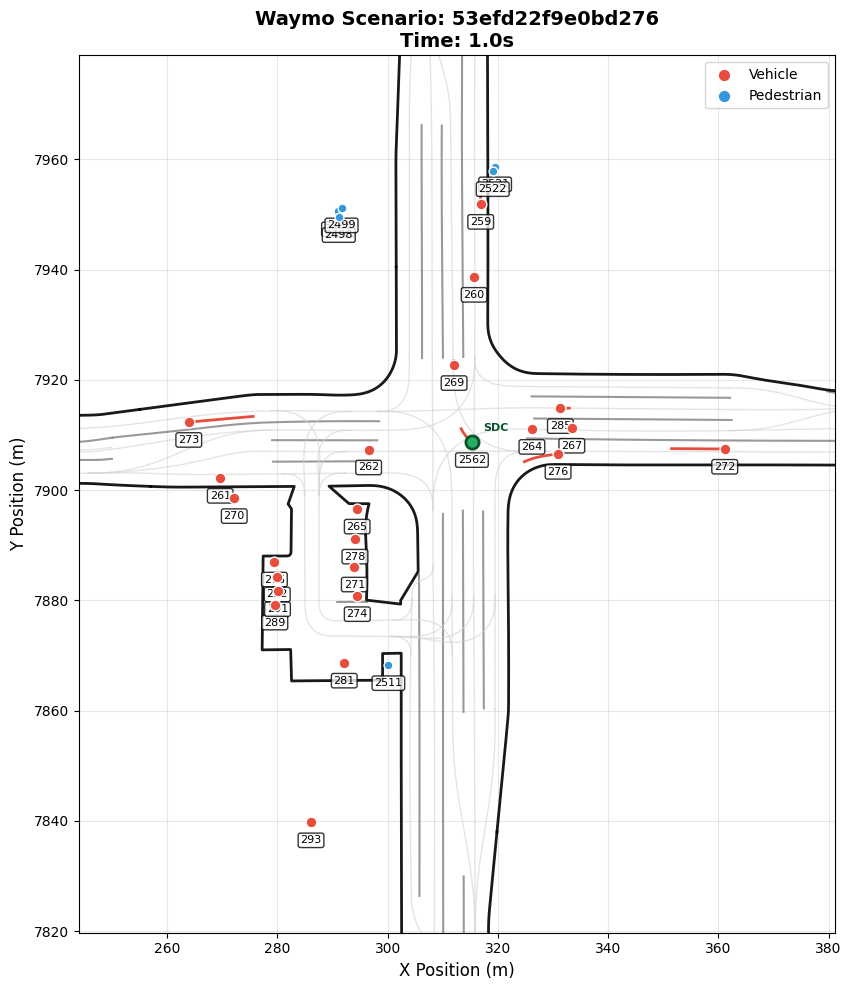

In [20]:
# SCENARIO VISUALIZATION:
import matplotlib.pyplot as plt

def visualize_scenario(scenario, timestep=0, show_future=True, figsize=(12, 10), print_stats=False):
    """Visualize a Waymo scenario."""
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    
    colors = {1: '#e74c3c', 2: '#3498db', 3: '#f39c12', 4: '#9b59b6'}
    type_names = {1: 'Vehicle', 2: 'Pedestrian', 3: 'Cyclist', 4: 'Other'}

    print(f"VISUALIZING SCENARIO: {scenario.scenario_id}")
    print(f" Time: {scenario.timestamps_seconds[timestep]:.1f}s")
    
    render_map_features(scenario, ax)
    
    render_agents(scenario, timestep, colors, ax)
    
    ax.set_aspect('equal')
    ax.grid(True, alpha=0.3)
    ax.set_xlabel('X Position (m)', fontsize=12)
    ax.set_ylabel('Y Position (m)', fontsize=12)
    ax.set_title(f'Waymo Scenario: {scenario.scenario_id}\nTime: {scenario.timestamps_seconds[timestep]:.1f}s', 
                fontsize=14, fontweight='bold')
    all_x = [state.center_x for track in scenario.tracks for state in track.states if state.valid]  # Auto-scale with margin
    all_y = [state.center_y for track in scenario.tracks for state in track.states if state.valid]
    if all_x and all_y:
        margin = 20
        ax.set_xlim(min(all_x) - margin, max(all_x) + margin)
        ax.set_ylim(min(all_y) - margin, max(all_y) + margin)
    for obj_type, color in colors.items():
        if obj_type in [t.object_type for t in scenario.tracks]:
            ax.scatter([], [], c=color, s=50, label=type_names[obj_type])
    ax.legend()
    plt.tight_layout()        

    if print_stats:
        agent_counts = {}
        for track in scenario.tracks:
            
            if timestep < len(track.states) and track.states[timestep].valid:
                agent_type = type_names.get(track.object_type, 'Other')
                agent_counts[agent_type] = agent_counts.get(agent_type, 0) + 1
            
        for agent_type, count in agent_counts.items():
            print(f"   - {count} {agent_type}{'s' if count != 1 else ''}")
            
        print(f"   - Duration: {scenario.timestamps_seconds[-1] - scenario.timestamps_seconds[0]:.1f}s")
        print(f"   - Map features: {len(scenario.map_features)}")

    return fig, ax

time = 10    # in 0.1s
fig, ax = visualize_scenario(training_dataset[0][0], timestep=time, show_future=True, print_stats=True)

In [15]:
# CONVERT SCENARIO TIMESTEP INTO PyG DATA (graph)
import torch
import numpy as np
from torch_geometric.data import Data, Batch

def initial_feature_vector(agent, stateIndex):
    object_types = {1: 'Vehicle', 2: 'Pedestrian', 3: 'Cyclist', 4: 'Other'}
    properties = [agent.states[stateIndex].center_x, agent.states[stateIndex].center_y, agent.states[stateIndex].velocity_x, agent.states[stateIndex].velocity_y, agent.states[stateIndex].valid]
    type_onehot = [1 if object_types[agent.object_type] == 'Vehicle' else 0,
                   1 if object_types[agent.object_type] == 'Pedestrian' else 0,
                   1 if object_types[agent.object_type] == 'Cyclist' else 0,
                   1 if object_types[agent.object_type] == 'Other' else 0 ]
    return torch.tensor(properties + type_onehot, dtype=torch.float32)

def build_edge_index_using_radius(position_tensor, radius, self_loops=False, valid_mask=None, min_distance=0.0):
    """Convert position tensor that holds (x,y) positions of agents into edge tensor (edge_index) OF SHAPE (2, E) for graph using radius."""
    pairwise_norm2_distances = torch.cdist(position_tensor, position_tensor)
    if valid_mask is not None:  # mask out pairs with invalid endpoints
        vm = torch.as_tensor(valid_mask, dtype=torch.bool, device=pairwise_norm2_distances.device)
        if vm.numel() != pairwise_norm2_distances.size(0):
            raise ValueError("valid_mask length must match number of positions")
        valid_pair = vm[:, None] & vm[None, :]   # True only if both endpoints valid
        pairwise_norm2_distances = pairwise_norm2_distances.clone()
        pairwise_norm2_distances[~valid_pair] = float('inf')
    if not self_loops:
        pairwise_norm2_distances.fill_diagonal_(float('inf'))
    edges_mask = (pairwise_norm2_distances <= float(radius)) & (pairwise_norm2_distances > float(min_distance))
    n1, n2 = torch.where(edges_mask)
    edge_index = torch.stack([n1, n2], dim=0)
    return edge_index

def get_data_from_agents(agents, node_features, positions_2D, agent_ids, valid_mask, timestep, use_valid_only):
    for agent in agents:
        if timestep >= len(agent.states):
            state = agent.states[-1]
        else:
            state = agent.states[timestep]

        valid = state.valid
        if use_valid_only and not valid:
            continue

        node_features.append(initial_feature_vector(agent, timestep))
        positions_2D.append([state.center_x, state.center_y])
        agent_ids.append(agent.id)
        valid_mask.append(1 if valid else 0)

def get_future_2D_trajectory_labels(scenario, agent_ids, initial_time, future_states):
    """Fixed: now takes scenario as first parameter instead of using global variable"""
    list_y = []
    id_to_agent = {t.id: t for t in scenario.tracks}
    for agent_id in agent_ids:
        agent = id_to_agent.get(agent_id)
        if agent is None:
            raise ValueError(f"Agent id {agent_id} not found in provided scenario.tracks")
        future_2d_positions = []
        for timestep in range(1, future_states+1):
            time = initial_time + timestep
            if time < len(agent.states) and agent.states[time].valid:
                future_2d_positions.append([agent.states[time].center_x, agent.states[time].center_y])
            else:
                # Pad with last known position
                last = agent.states[min(time, len(agent.states) - 1)]
                future_2d_positions.append([last.center_x, last.center_y])
        
        current_2d_position_t = torch.tensor([agent.states[initial_time].center_x, agent.states[initial_time].center_y], dtype=torch.float32)
        future_2d_positions_t = torch.tensor(future_2d_positions, dtype=torch.float32)

        future_2d_positions_in_offsets = future_2d_positions_t - current_2d_position_t
        list_y.append(future_2d_positions_in_offsets.flatten())
    return list_y

def scenario_to_pyg_data(scenario, timestep, radius, future_states=1, use_valid_only=True):
    """Converts scenarion into PyG data - graph."""
    node_features = []
    positions_2D = []
    agent_ids = []
    valid_mask = []
    get_data_from_agents(scenario.tracks, node_features, positions_2D, agent_ids, valid_mask, timestep, use_valid_only)

    if len(node_features) == 0:
        return None

    x = torch.stack(node_features)
    positions_2D_tensor = torch.tensor(positions_2D, dtype=torch.float32)
    edge_index = build_edge_index_using_radius(positions_2D_tensor, radius, valid_mask=valid_mask, min_distance=0.1)

    # Fixed: pass scenario as first parameter
    y = torch.stack(get_future_2D_trajectory_labels(scenario, agent_ids, timestep, future_states))

    data = Data(x=x, edge_index=edge_index, pos=positions_2D_tensor, y=y)
    data.agent_ids = agent_ids
    data.valid_mask = torch.tensor(valid_mask, dtype=torch.bool)
    return data

In [16]:
# VISUALIZE SCENARIO WITH GRAPH EDGES
import matplotlib.pyplot as plt

def show_distances(pos, src_idx, dst_idx, x_coords, y_coords):
    dist = np.sqrt((pos[src_idx, 0] - pos[dst_idx, 0])**2 + (pos[src_idx, 1] - pos[dst_idx, 1])**2)
    mid_x = (x_coords[0] + x_coords[1]) / 2
    mid_y = (y_coords[0] + y_coords[1]) / 2
    ax.annotate(f'{dist:.1f}m', xy=(mid_x, mid_y), fontsize=6, color='blue', ha='center', alpha=0.6)

def visualize_scenario_with_graph(scenario, timestep, radius, figsize=(14, 12), show_future=True, show_edge_distances=False, show_scenario_analysis=False):

    if show_scenario_analysis:
        analyze_scenario(scenario)
        analyze_scenario_agents(scenario)

    graph_data = scenario_to_pyg_data(scenario, timestep, radius, future_states=10)
    if graph_data is None:
        print("No valid agents at this timestep!")
        return None, None, None

    fig, ax = plt.subplots(1, 1, figsize=figsize)
    colors = {1: '#e74c3c', 2: '#3498db', 3: '#f39c12', 4: '#9b59b6'}
    type_names = {1: 'Vehicle', 2: 'Pedestrian', 3: 'Cyclist', 4: 'Other'}
    print(f"VISUALIZING SCENARIO WITH GRAPH: {scenario.scenario_id}")
    print(f" Time: {scenario.timestamps_seconds[timestep]:.1f}s")
    print(f" Graph: {graph_data.num_nodes} nodes, {graph_data.num_edges} edges")

    render_map_features(scenario, ax)

    print(f" Rendering {graph_data.num_edges} graph edges...")
    edge_index = graph_data.edge_index
    pos = graph_data.pos.numpy()
    for i in range(edge_index.shape[1]):
        src_idx = edge_index[0, i].item()
        dst_idx = edge_index[1, i].item()
        x_coords = [pos[src_idx, 0], pos[dst_idx, 0]]
        y_coords = [pos[src_idx, 1], pos[dst_idx, 1]]
        ax.plot(x_coords, y_coords, 'blue', linewidth=1.2, alpha=0.4, zorder=5)
        if show_edge_distances:
            show_distances()

    render_agents(scenario, timestep, colors, ax, show_future=show_future)

    ax.set_aspect('equal')
    ax.grid(True, alpha=0.3)
    ax.set_xlabel('X Position (m)', fontsize=12)
    ax.set_ylabel('Y Position (m)', fontsize=12)
    ax.set_title(f'Waymo Scenario with Graph Edges (radius={radius}m)\n'
                f'Scenario: {scenario.scenario_id}, Time: {scenario.timestamps_seconds[timestep]:.1f}s\n'
                f'{graph_data.num_nodes} nodes, {graph_data.num_edges} edges', 
                fontsize=14, fontweight='bold')
    all_x = [state.center_x for track in scenario.tracks for state in track.states if state.valid]
    all_y = [state.center_y for track in scenario.tracks for state in track.states if state.valid]
    if all_x and all_y:
        margin = 20
        ax.set_xlim(min(all_x) - margin, max(all_x) + margin)
        ax.set_ylim(min(all_y) - margin, max(all_y) + margin)
    for obj_type, color in colors.items():
        if obj_type in [t.object_type for t in scenario.tracks]:
            ax.scatter([], [], c=color, s=50, label=type_names[obj_type])
    ax.plot([], [], 'blue', linewidth=2, alpha=0.4, label=f'Graph edges (≤{radius}m)')
    ax.legend()
    plt.tight_layout()

    agent_counts = {}
    for track in scenario.tracks:
        if timestep < len(track.states) and track.states[timestep].valid:
            agent_type = type_names.get(track.object_type, 'Other')
            agent_counts[agent_type] = agent_counts.get(agent_type, 0) + 1
    print(" Agents in graph:")
    for agent_type, count in agent_counts.items():
        print(f"   - {count} {agent_type}{'s' if count != 1 else ''}")
    if graph_data.num_edges > 0:
        avg_degree = graph_data.num_edges / graph_data.num_nodes
        print(f" Average degree: {avg_degree:.2f} edges per node")
    
    return fig, ax, graph_data

VISUALIZING SCENARIO WITH GRAPH: 53efd22f9e0bd276
 Time: 0.0s
 Graph: 28 nodes, 264 edges
 Rendering map features...
 Rendering 264 graph edges...
 Rendering agents...
 Agents in graph:
   - 23 Vehicles
   - 5 Pedestrians
 Average degree: 9.43 edges per node
 Agents in graph:
   - 23 Vehicles
   - 5 Pedestrians
 Average degree: 9.43 edges per node


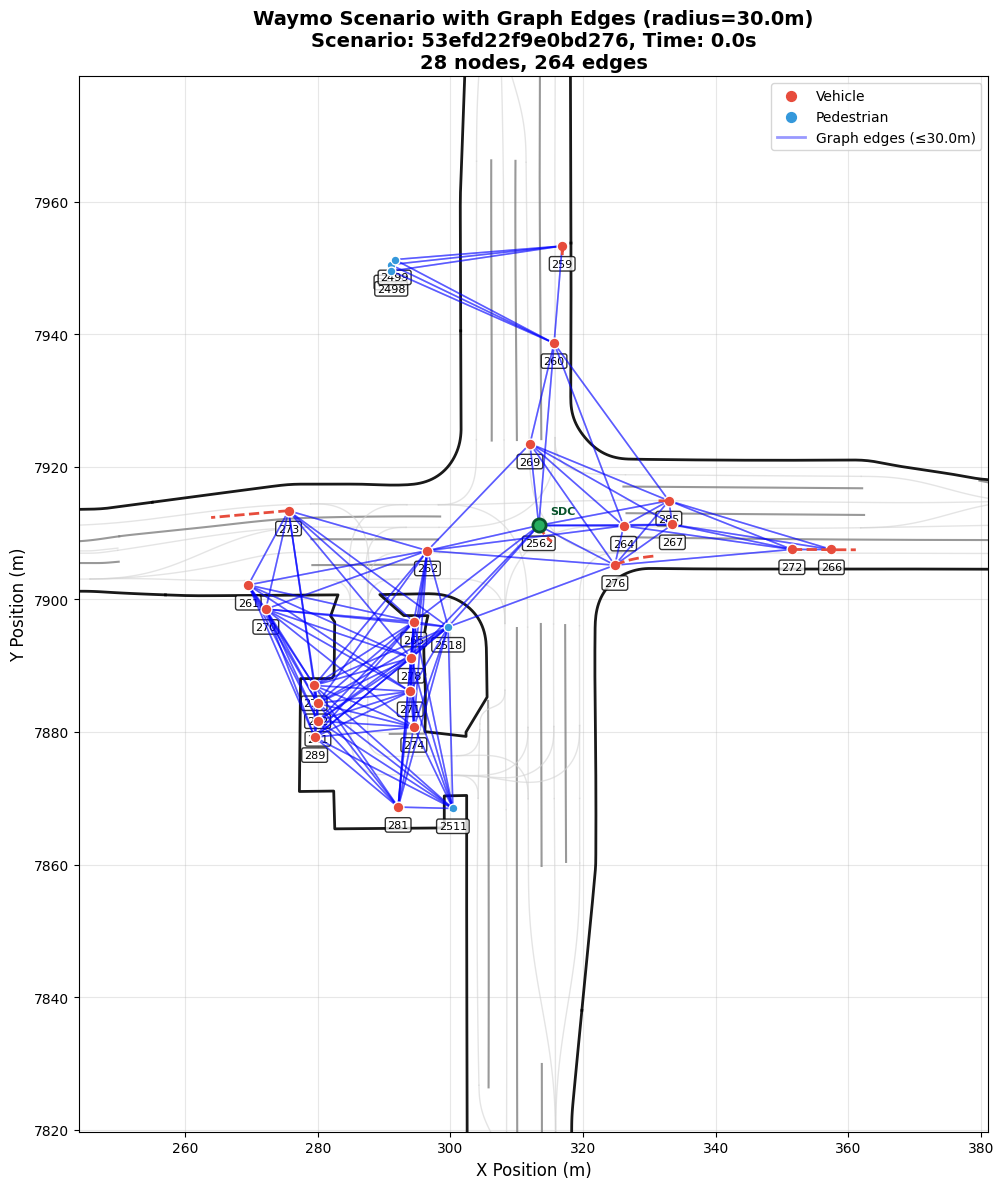

In [21]:
# TEST: Visualize scenario with graph edges at different radii
time = 0
fig1, ax1, graph1 = visualize_scenario_with_graph(training_dataset[0][0], timestep=time, radius=30.0, show_future=True)


VISUALIZING SCENARIO: 5d3dd267ff0560f8
 Time: 0.0s
 Rendering map features...
 Rendering agents...
VISUALIZING SCENARIO WITH GRAPH: 5d3dd267ff0560f8
 Time: 0.0s
 Graph: 59 nodes, 396 edges
 Rendering map features...
 Rendering 396 graph edges...
 Rendering agents...
VISUALIZING SCENARIO WITH GRAPH: 5d3dd267ff0560f8
 Time: 0.0s
 Graph: 59 nodes, 396 edges
 Rendering map features...
 Rendering 396 graph edges...
 Rendering agents...
 Agents in graph:
   - 54 Vehicles
   - 5 Pedestrians
 Average degree: 6.71 edges per node
VISUALIZING SCENARIO: 5d3dd267ff0560f8
 Time: 1.0s
 Rendering map features...
 Rendering agents...
 Agents in graph:
   - 54 Vehicles
   - 5 Pedestrians
 Average degree: 6.71 edges per node
VISUALIZING SCENARIO: 5d3dd267ff0560f8
 Time: 1.0s
 Rendering map features...
 Rendering agents...
VISUALIZING SCENARIO WITH GRAPH: 5d3dd267ff0560f8
 Time: 1.0s
 Graph: 57 nodes, 362 edges
 Rendering map features...
 Rendering 362 graph edges...
 Rendering agents...
VISUALIZING SCENA

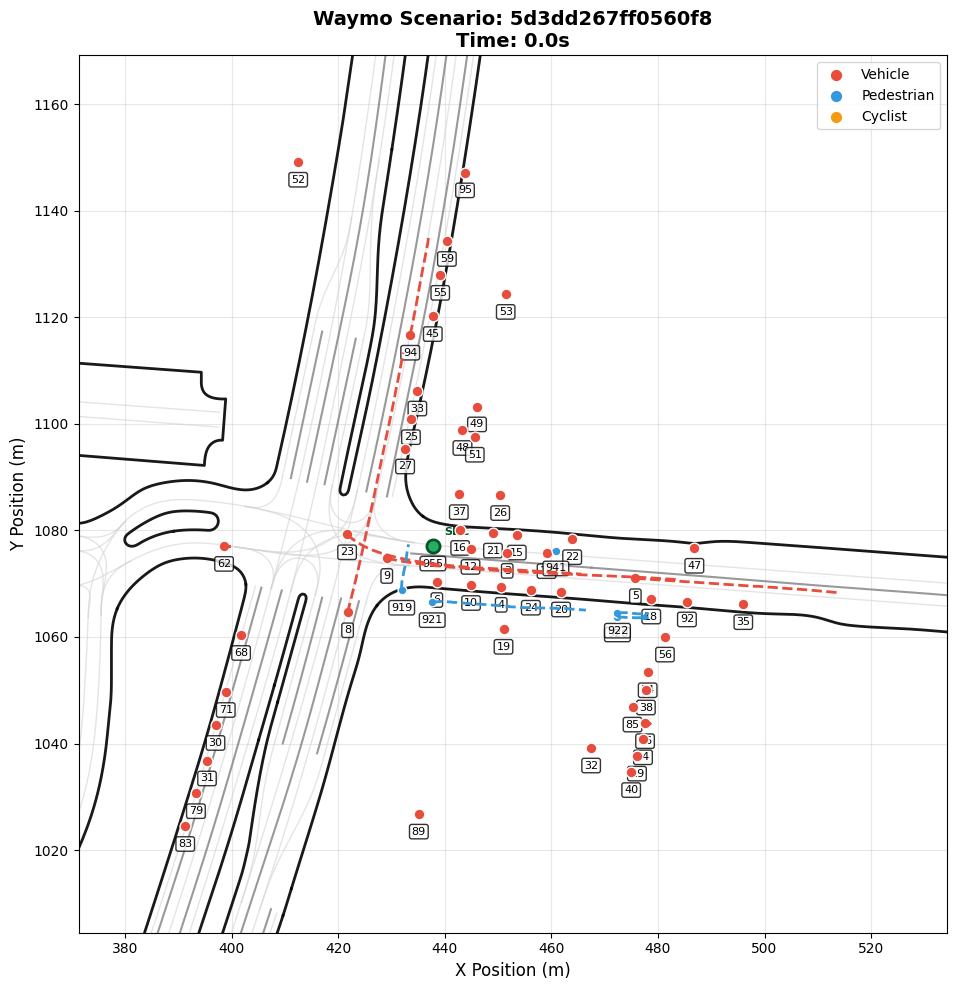

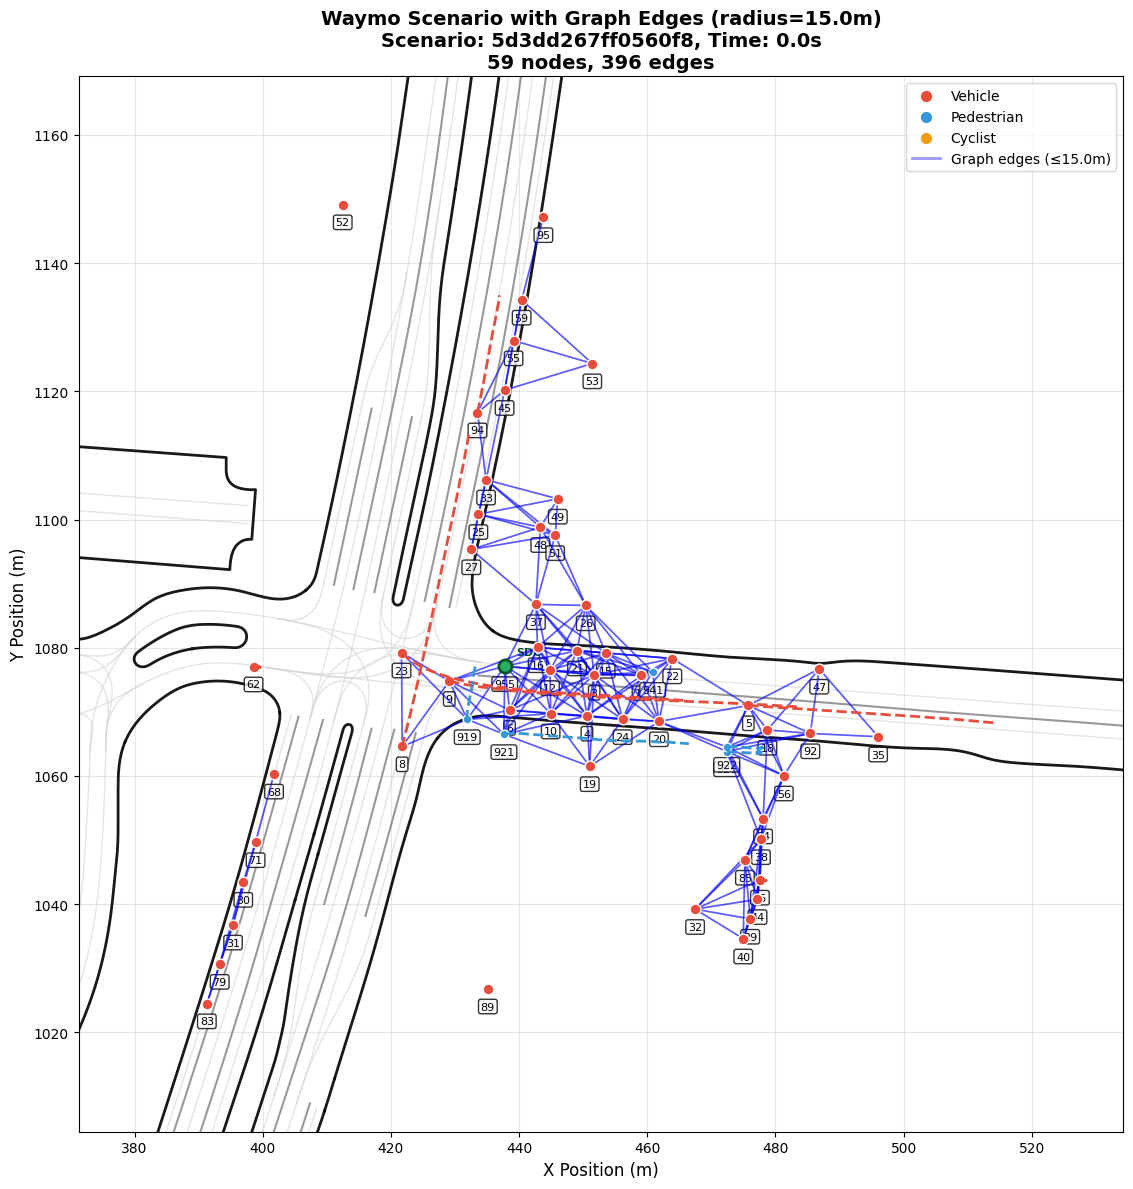

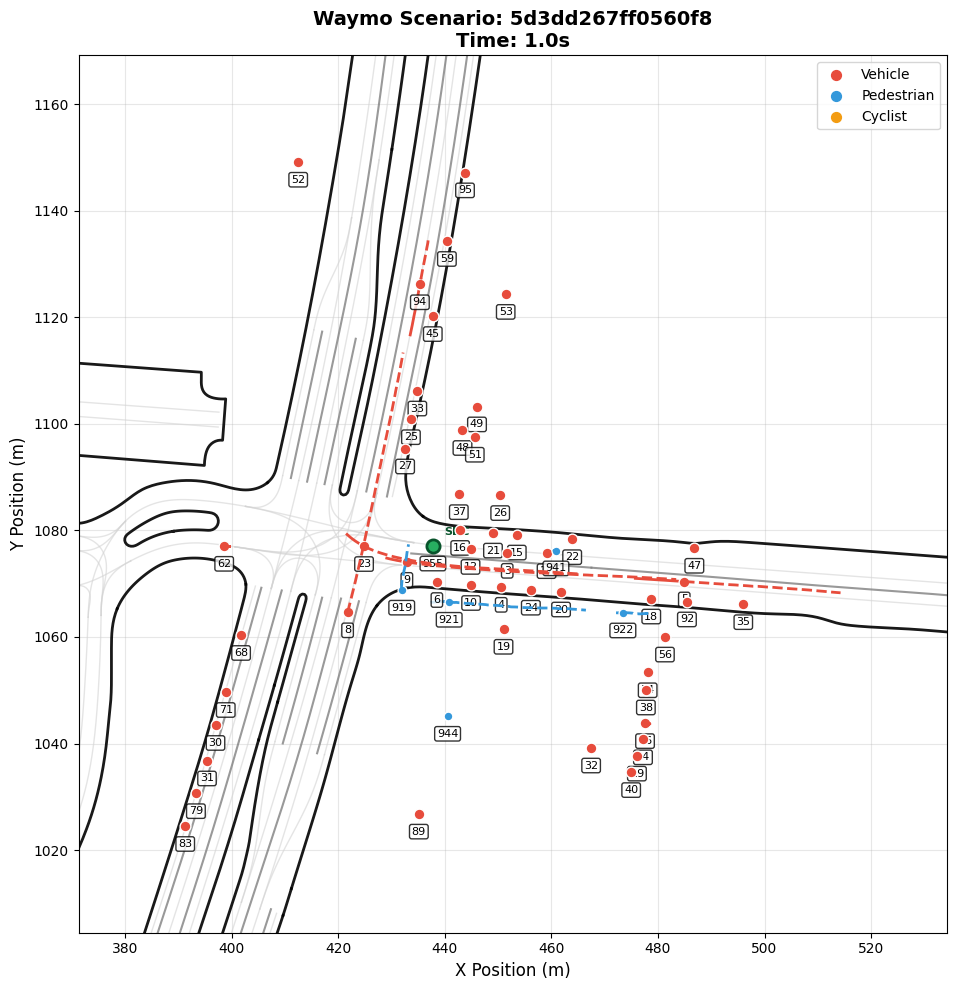

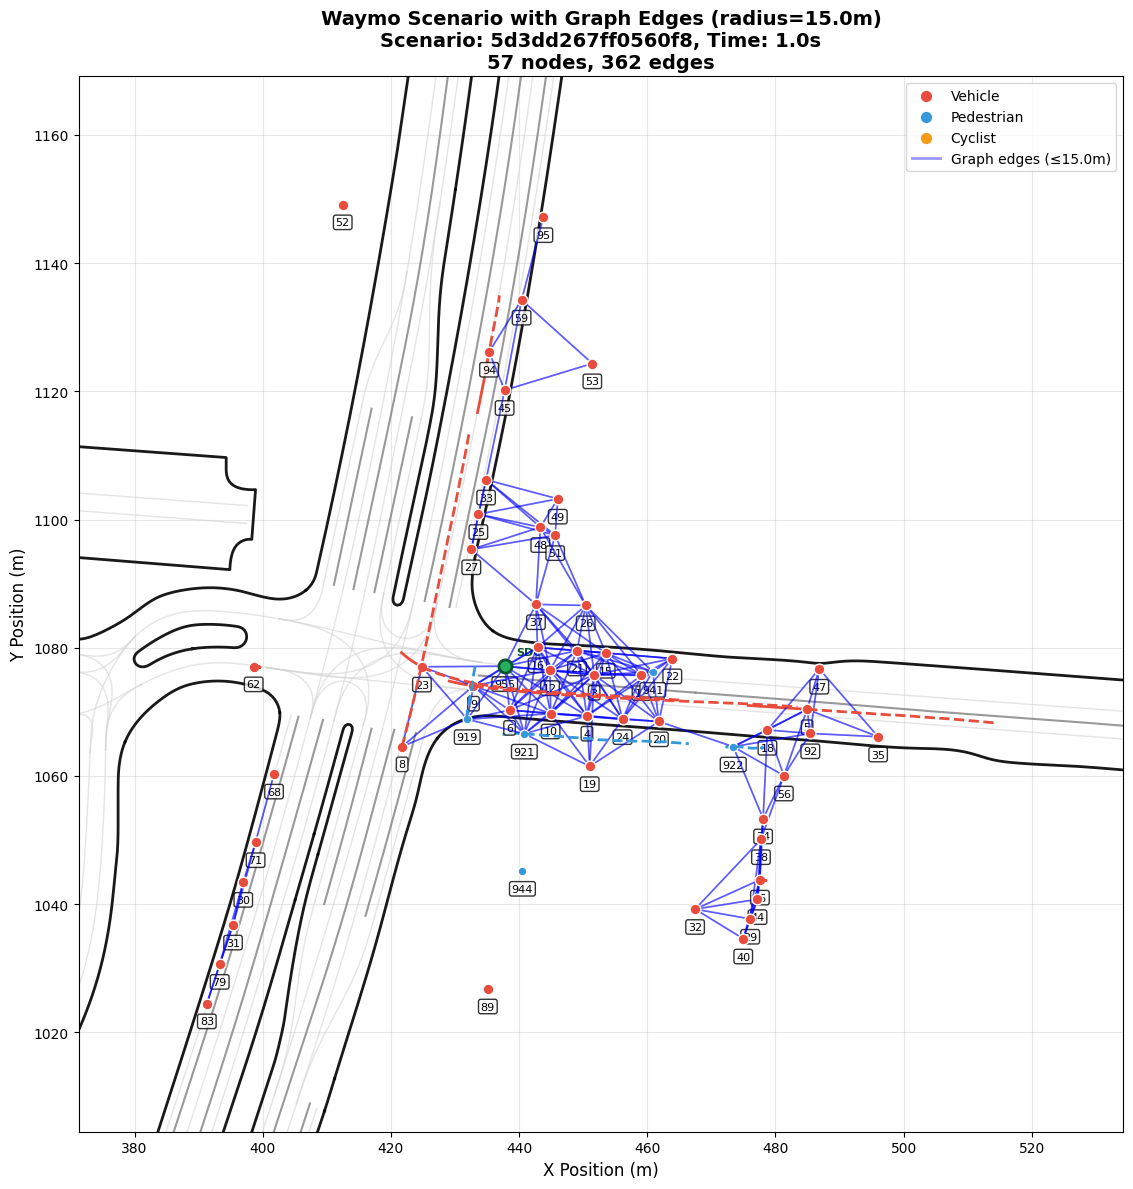

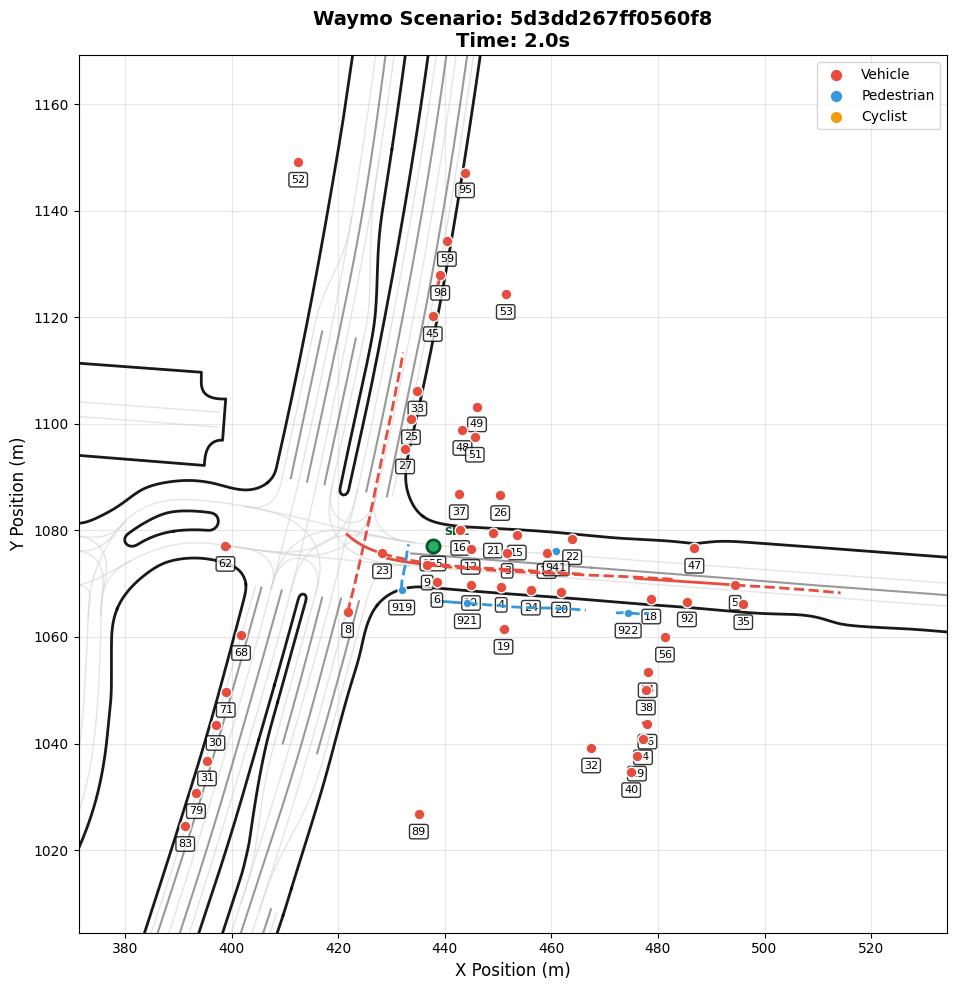

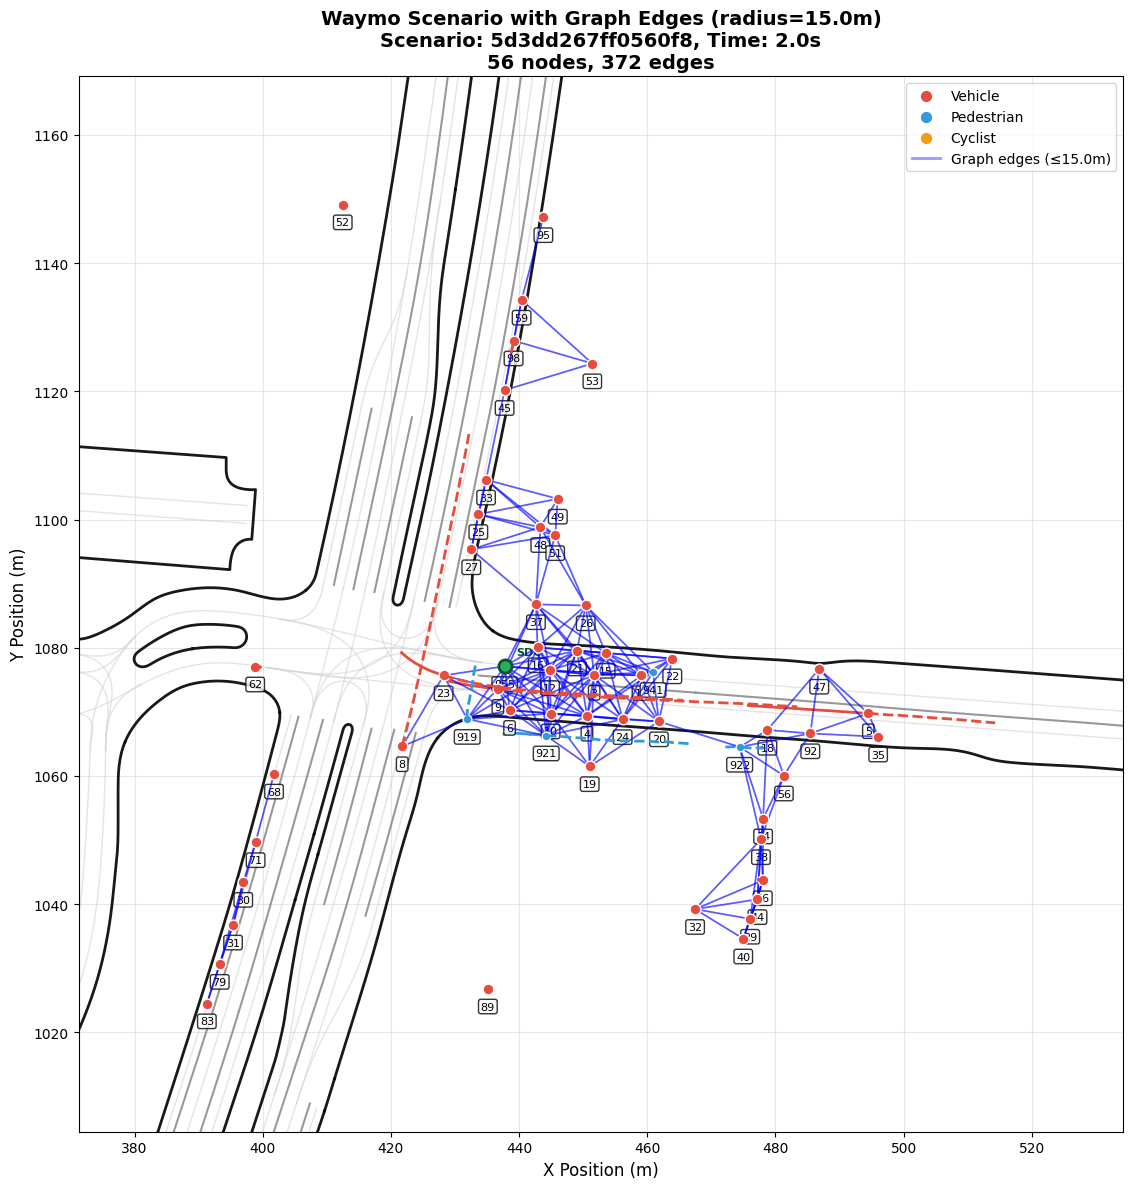

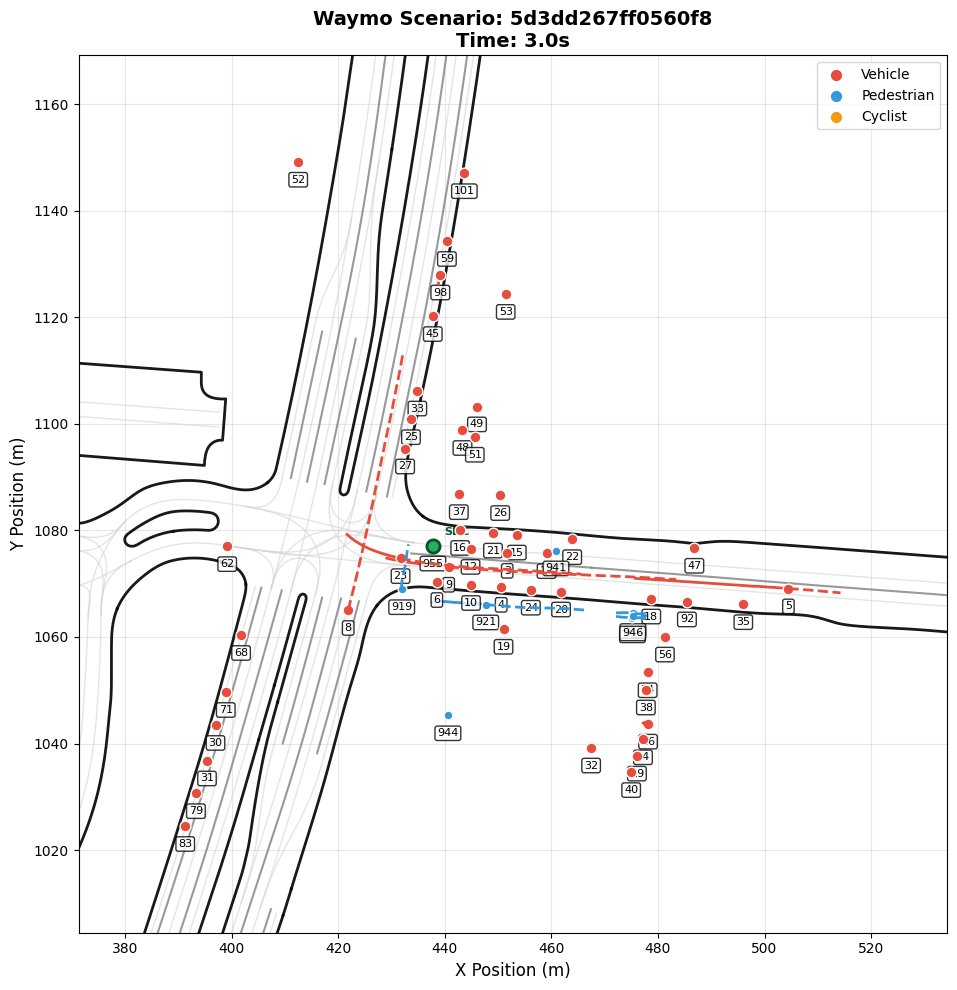

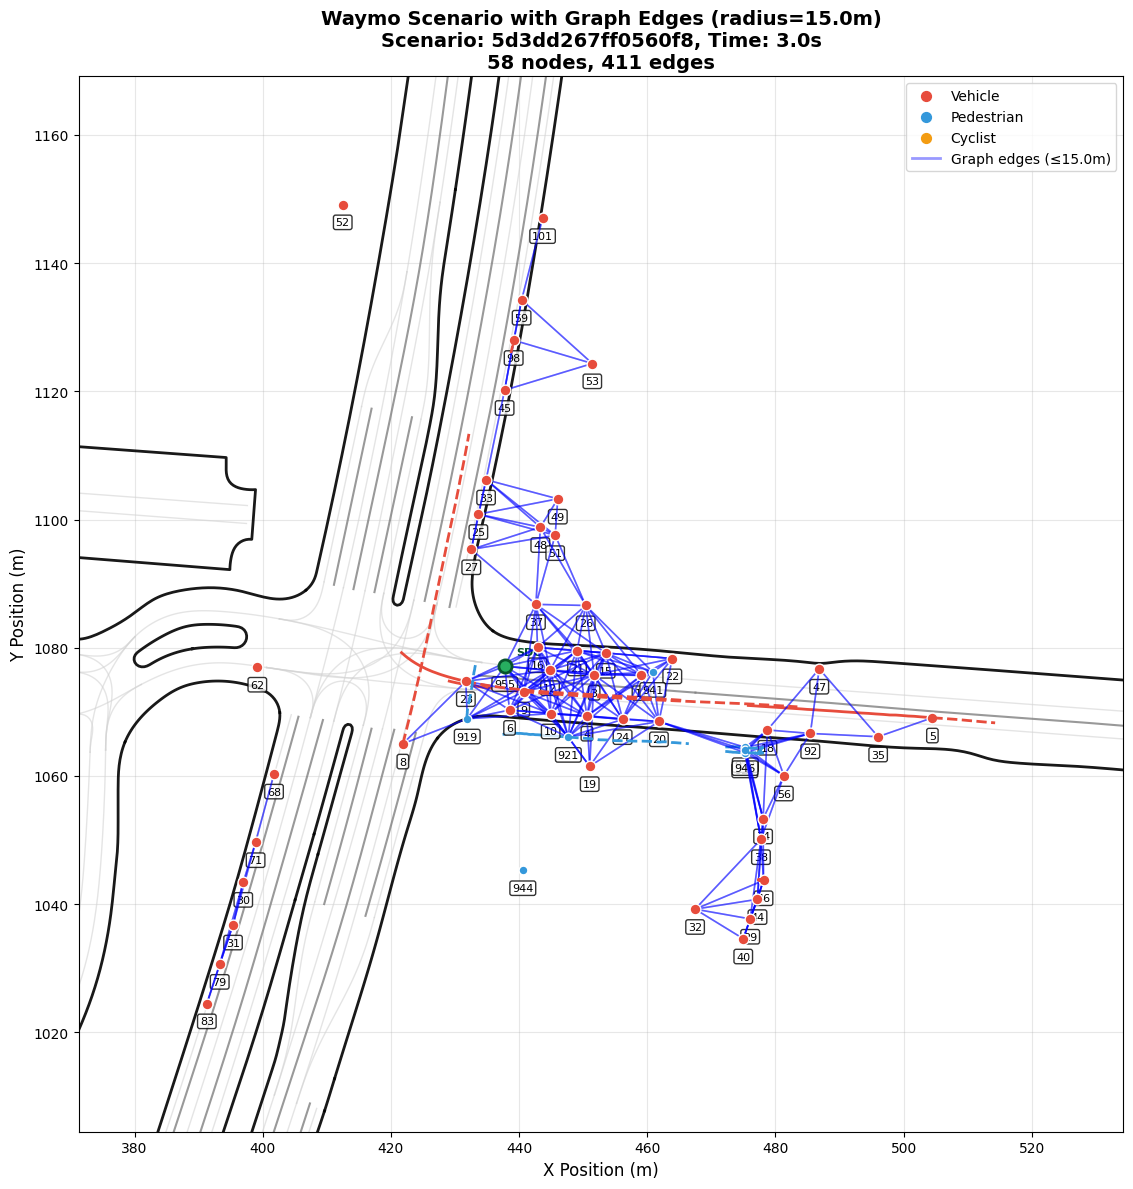

In [30]:
scenario = validation_dataset[0][22]
for time in range(0, 40, 10):
    fig2, ax2 = visualize_scenario(scenario, time)
    fig3, ax3, graph3 = visualize_scenario_with_graph(scenario, timestep=time, radius=15.0, show_future=True)

#fig3, ax3, graph3 = visualize_scenario_with_graph(training_dataset[0][2], timestep=time, radius=30.0, show_edge_distances=True)